In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Introduction
2. Load and check data
* 2.1 load data
* 2.2 Outlier detection
* 2.3 joining train and test set
* 2.4 check for null and missing values
3. Feature analysis
* 3.1 Numerical values
* 3.2 Categorical values
4. Filling missing values
* 4.1 Age
5. Feature Engineering
* 5.1 Name/Title
* 5.2 Family Size
* 5.3 Cabin
* 5.4 Ticket
6. Modeling
* 6.1 Simple modeling
  * 6.1.1 Cross validate models
  * 6.1.2 Hyperparameter tunning for best models
  * 6.1.3 Plots learning curves
  * 6.1.4 Feature importances of the tree based classifiers
* 6.2 Ensemble models
   * 6.2.1 Combining models
* 6.3 Prediction
  * 6.3.1 Predict and Submit results

## 1. Introduction
첫 번째로 피처 분석을 하며 엔지니어링에 집중하겠습니다. 마지막 파트는 voting 을 통해 타이타닉의 모델링과 생존을 예측에 관한 것을 고려합니다.  
  
이 스크립트는 크게 세 부분으로 나뉩니다:  
* Feature analysis  
* Feature engineering
* Modeling

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data
### 2.1 Load data

In [41]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/Titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/Titanic/test.csv')
IDtest = test["PassengerId"]

### 2.2 Outlier detection

In [33]:
def detect_outliers(df, n, features):
  # IQR(Inter Quantile Range) 방식으로 아웃라이어 처리하기

  outlier_indices = []

  for col in features:
    # 1st quantile(25%)
    Q1 = np.percentile(df[col], 25)
    # 3rd quantile(75%)
    Q3 = np.percentile(df[col], 75)
    # Interquantile rane(IQR)
    IQR = Q3 - Q1

    outlier_step = 1.5 * IQR

    # 인덱스의 리스트 정의 피처 컬럼의 아웃라이어에 대한
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    # 정의한 컬럼들의 아웃라이어 인덱스를 추가하기
    outlier_indices.extend(outlier_list_col)

    # 3개 이상의 아웃라이어를 포함하는 관측치들을 선택하기
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list( k for k, v in outlier_indices.items() if v > n) 

  return multiple_outliers

Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"]) # 왜 3개 이상의 중복 결측치를 제거하는지

## Fare를 제외한 피처들은 아웃라이어가 있는지 의문. 아웃라이어가 있다고 하더라도 크지 않은  수준일텐데 왜 제거하는지?

In [43]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 아웃라이어를 관측했습니다. 28, 89, 342 승객은 높은 티켓 비용을 냈습니다. 나머지 7명은 매우 높은 SibSp 값을 가졌습니다.

### 2.3 joining train and test set

In [44]:
train_len = len(train)
dataset = pd.concat(objs = [train, test], axis=0).reset_index(drop=True)

train과 test 데이터셋을 합쳤습니다. 따라서 같은 피처의 수를 얻을 수 있습니다. 범주형 변환을 할 때

### check for null and missing values

In [45]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Age와 Cabin features는 결측치에 있어 중요한 파트입니다.  
Susvived 결측치는 test 데이터셋에 해당합니다. (Survived 컬럼은 테스트셋에 없으며 train, test 셋을 합칠 때 NaN값으로 대체했습니다.)

In [46]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [47]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [48]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [49]:
#summarize data and get statistics

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Feature analysis

### 3.1 Numerical values

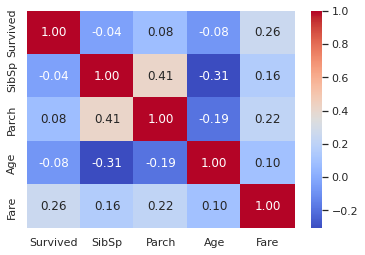

In [53]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt = ".2f", cmap="coolwarm")

Fare feature만이 생존 확률과 의미 있는 상관관계를 가지고 있는듯 합니다.  
  
이는 다른 피처들이 쓸모 없다는 의미는 아닙니다. 이러한 피처들의 부분은 생존과 관계가 있을 수 있습니다. 이를 결정 짓기 위해 이러한 피처들의 세부사항들을 탐색해야 합니다.

**SIbSp**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


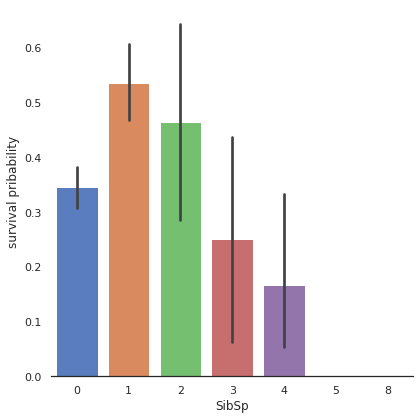

In [62]:
g = sns.factorplot(x = "SibSp", y = "Survived", data=train, kind="bar", size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival pribability")

많은 형제와 배우자를 둔 승객들은 생존률이 낮은듯 보입니다.  
  
혼자, 혹은 두 명이 서로 함께 있는 (SibSp 1or 2) 승객들은 생존률이 높은 것 같습니다.  
  
이러한 관찰은 꽤 흥미로운데, 우리는 새로운 피처로 고려할 수 있습니다. 이러한 범주를 설명하는

**Parch** 

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


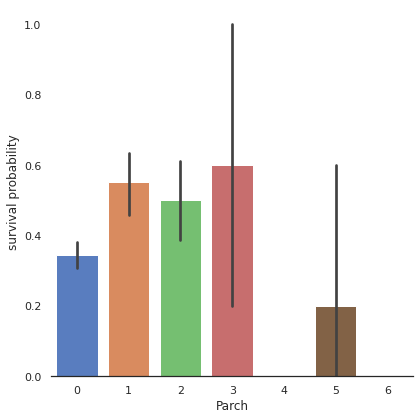

In [64]:
g = sns.factorplot(x = "Parch", y = "Survived", data = train, kind = "bar", size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

작은 가족들은 생존 확률이 더 높습니다. 싱글(Pacrh 0), 중간(Parch 3,4) 그리고 대가족(Parch 5,6)보다.  
  
부모/아이가 3명인 승객들의 생존에 있어 중요한 표준편차가 있다는 것에 유의하세요.